# Testing Action Recognition by image using Blip

In the Animal Kingdom dataset, action recognition is tested for unseen types of aniimals. Video clips of 6 action classes (moving, eating, attending, swimming, sensing, and keeping still). Then we select 4 animal types (birds, fishes, frogs, snakes) for training. Then we select 5 animal types for testing (lizards, primates, spiders, orthopteran insects, water fowls)

#### action indexes:
moving = 78 \
eating = 40 \
attending = 2 \
swimming = 123 \
sensing = 102 \
keeping still = 68

## Data Preparation

In [44]:
import pandas as pd
import csv
import json
from tqdm import tqdm

In [45]:
# go through pose estimation data to find the frames of animals for training and testing dataset that correspond with the correct classes

# the training and val subclasses data structures are organized where the key of the dict is the official subclass name found the in the data, and the value is the alias we will use for the clip model

training_subclasses = {
    "Bird": "bird",
    "Fish": "fish",
    "Frog / Toad": "frog",
    "Snake / Cobra / Viper / Python": "snake"
}

# spiders and orthopteran insects not found in Animal Kingdom dataset
val_subclasses = {
    "Lizard / Gecko / Draco / Iguana / Chamelon": "lizard",
    "Primate / Monkey / Macaque / Baboon / Chimpanzee / Gorilla / Orangutan / Langur": "primate",
    "Water bird / Duck / Swan / Goose": "water fowl"
}

all_data = []
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/train.json", "r")
train_set = json.load(f)
f.close()
all_data = all_data + train_set
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/test.json", "r")
test_set = json.load(f)
f.close()
all_data = all_data + test_set

# example data element
# {
    # ak_P1/0000: {
    #     image_subclass: penguin,
    #     dataset: train,
    #     action: 3
    # }
# }
data = {}

# add all the animals that are listed in the training or testing dataset
for i in range(len(all_data)):
    animal = all_data[i]
    if animal["animal_subclass"] in training_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": training_subclasses[animal["animal_subclass"]],
            "dataset": "train"
        }
    if animal["animal_subclass"] in val_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": val_subclasses[animal["animal_subclass"]],
            "dataset": "validation"
        }

In [46]:
valid_actions = ["78", "40", "2", "123", "102", "68"]

# create list of images from the training and testing set
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/train.csv"
frame_train = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/val.csv"
frame_val = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])

combined_frame = pd.concat([frame_train, frame_val])

for row in combined_frame.itertuples(index=False):
    path = row[3]
    if path in data:
        action_indexes = row[4].split(",")
        # as per the paper, only include frames with 1 action
        if len(action_indexes) == 1:
            if action_indexes[0] in valid_actions:
                data[path]["action"] = action_indexes[0]

# delete all the frames that don't have an action
for key in list(data.keys()):
    if "action" not in data[key]:
        del data[key]
        

create the strings that are going to be fed into the clip model

In [47]:
df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")

training_strings = []
val_strings = []

for subclass in training_subclasses:
    for action in valid_actions:
        training_strings.append(f"a {training_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

for subclass in val_subclasses:
    for action in valid_actions:
        val_strings.append(f"a {val_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

## Testing

test for "a `{animal}` is `{action}`". example: "a dog is swimming"

In [48]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
import matplotlib.pyplot as plt

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image_dir = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/image/"

database_train = {
    "bird": [],
    "fish": [],
    "frog": [],
    "snake": []
}
database_val = {
    "lizard": [],
    "primate": [],
    "water fowl": []
}
for image_path, _ in tqdm(data.items()):
# for image_path in data:
    label_num = data[image_path]["action"]
    full_image_path = image_dir + image_path
    
    converted_label = df.at[int(label_num), 'action'].lower()
    # valid_actions = []
    # for action in labels:
    #     valid_actions.append(df.at[int(action), 'action'].lower())

    image = Image.open(full_image_path)

    inputs = None
    if data[image_path]["dataset"] == "train":
        inputs = processor(text=training_strings, images=image, return_tensors="pt", padding=True)
    else:
        inputs = processor(text=val_strings, images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    index = torch.argmax(probs)

    if data[image_path]["dataset"] == "train":
        action = training_strings[index].split(" ")[-1]
        if action == converted_label:
            database_train[data[image_path]["image_subclass"]].append(1)
        else:
            database_train[data[image_path]["image_subclass"]].append(0)
    else:
        action = val_strings[index].split(" ")[-1]
        if action == converted_label:
            database_val[data[image_path]["image_subclass"]].append(1)
        else:
            database_val[data[image_path]["image_subclass"]].append(0)

100%|██████████| 7247/7247 [10:18<00:00, 11.73it/s]


In [49]:
# convert the dictionary values to percentages

for animal in database_train:
    database_train[animal] = database_train[animal].count(1) / len(database_train[animal])

for animal in database_val:
    database_val[animal] = database_val[animal].count(1) / len(database_val[animal])

{'lizard': 0.17217524980784013, 'primate': 0.1414141414141414, 'water fowl': 1.0}


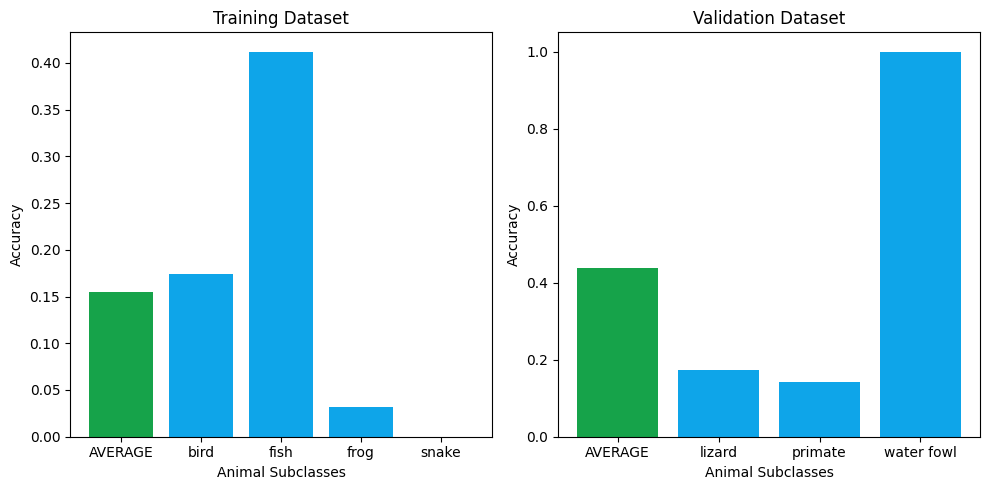

In [65]:
import matplotlib.pyplot as plt

categories1 = list(database_train.keys())
values1 = list(database_train.values())
categories1.insert(0, "AVERAGE")
values1.insert(0, sum(values1) / len(values1))
categories2 = list(database_val.keys())
values2 = list(database_val.values())
categories2.insert(0, "AVERAGE")
values2.insert(0, sum(values2) / len(values2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first bar chart on the first subplot
ax1.bar(categories1, values1, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax1.set_xlabel('Animal Subclasses')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training Dataset')

# Plot the second bar chart on the second subplot
ax2.bar(categories2, values2, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax2.set_xlabel('Animal Subclasses')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Dataset')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()
